# Deep Learning Model for Ship Detection in Satellite Imagery

[Inspiration](https://github.com/abhinavsagar/Kaggle-Solutions)

In [1]:
# import packages 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.morphology import label
from skimage.data import imread
import os
import time
import sys
%matplotlib inline

In [ ]:
TRAINING_VALIDATION_RATIO = 0.2
WORKING_DIR = '/kaggle/working'
INPUT_DIR = '/kaggle/input'
OUTPUT_DIR = '/kaggle/output'
LOGS_DIR = os.path.join(WORKING_DIR, "logs")
TRAIN_DATA_PATH = os.path.join(INPUT_DIR, 'airbus-ship-detection/train_v2')
TEST_DATA_PATH = os.path.join(INPUT_DIR, 'airbus-ship-detection/test_v2')
SAMPLE_SUBMISSION_PATH = os.path.join(INPUT_DIR, 'airbus-ship-detection/sample_submission_v2.csv')
TRAIN_SHIP_SEGMENTATIONS_PATH = os.path.join(INPUT_DIR, 'airbus-ship-detection/train_ship_segmentations_v2.csv')
MASK_RCNN_PATH = os.path.join(WORKING_DIR, 'Mask_RCNN-master')


test_ds = os.listdir(TEST_DATA_PATH)
train_ds = os.listdir(TRAIN_DATA_PATH)

print('Working Dir:', WORKING_DIR, os.listdir(WORKING_DIR))
print('Input Dir:', INPUT_DIR, os.listdir(INPUT_DIR))
print('train dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(train_ds)))
print('test dataset from: {}, {}'.format(TRAIN_DATA_PATH, len(test_ds)))
print(TRAIN_SHIP_SEGMENTATIONS_PATH)

In [4]:
# set working directories
DATA_DIR = r'D:\data\kaggle.ShipDetection\airbus-ship-detection'
TRAIN_DIR = r'D:\data\kaggle.ShipDetection\airbus-ship-detection\train_v2'

In [5]:
# image resolution
IMAGE_WIDTH = 768
IMAGE_HEIGHT = 768
SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT)

In [12]:
# classification 
SHIP_CLASS_NAME = 'ship'

In [6]:
training_masks = pd.read_csv(os.path.join(DATA_DIR,'train_ship_segmentations_v2.csv'))
training_masks.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


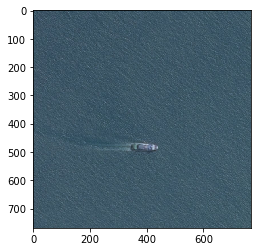

In [7]:
test_image = imread(os.path.join(TRAIN_DIR,'000155de5.jpg'))
plt.imshow(test_image)

In [8]:
def multi_rle_encode(img):
    """finds connected pixels in image"""
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    pixels = img.T.flatten() 
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=SHAPE):
    """convert mask rle to pixel array"""
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def masks_as_image(in_mask_list, shape=SHAPE):
    """convert mask pixle array to image"""
    all_masks = np.zeros(shape, dtype = np.int16)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def shows_decode_encode(image_id, path=TRAIN_DIR):
    """show raw image, mask and image+mask"""
    fig, axarr = plt.subplots(1, 3, figsize = (10, 5))
    img_0 = imread(os.path.join(path, image_id))
    axarr[0].imshow(img_0)
    axarr[0].set_title(image_id)
    
    rle_1 = training_masks.query('ImageId=="{}"'.format(image_id))['EncodedPixels']
    img_1 = masks_as_image(rle_1)
    axarr[1].imshow(img_1[:, :, 0])
    axarr[1].set_title('Ship Mask')
    
    rle_2 = multi_rle_encode(img_1)
    img_2 = masks_as_image(rle_2)
    axarr[2].imshow(img_0)
    axarr[2].imshow(img_2[:, :, 0], alpha=0.3)
    axarr[2].set_title('Encoded & Decoded Mask')
    
    plt.show()
    print(image_id , ' Check Decoding->Encoding',
          'RLE_0:', len(rle_1), '->',
          'RLE_1:', len(rle_2))

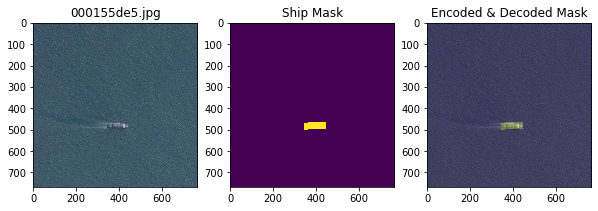

000155de5.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


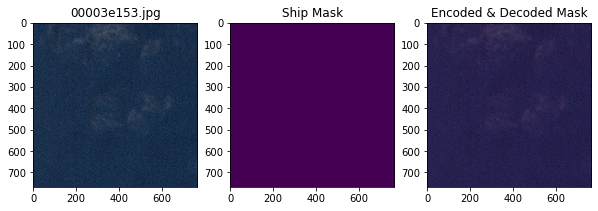

00003e153.jpg  Check Decoding->Encoding RLE_0: 1 -> RLE_1: 0


It could be different when there is no mask.


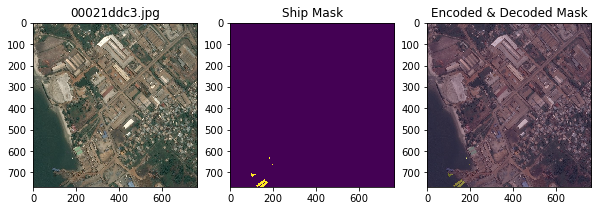

00021ddc3.jpg  Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4


It could be different when there are masks overlapped.


In [9]:
shows_decode_encode('000155de5.jpg')
shows_decode_encode('00003e153.jpg')
print('\n\nIt could be different when there is no mask.')
shows_decode_encode('00021ddc3.jpg')
print('\n\nIt could be different when there are masks overlapped.')

## How many ships are there in each image?

,ImageId,ships,RleMaskList
155241,ce6ab11c4.jpg,1,[164295 1 165062 3 165829 5 166596 6 167363 8 ...
55685,4a379a202.jpg,1,[291422 10 292190 10 292958 10 293726 10 29449...
132878,b0ab145d0.jpg,2,[98029 1 98795 3 99561 6 100328 7 101097 7 101...


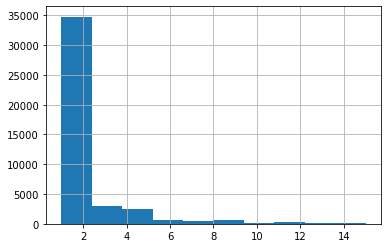

In [10]:
# add field to images that contain ships
training_masks['ships'] = training_masks['EncodedPixels'].map(lambda encoded_pixels: 1 if isinstance(encoded_pixels, str) else 0)

# ships per image
unique_img_ids = training_masks.groupby('ImageId').agg({'ships': 'sum'})

# put ship-masks into a list
unique_img_ids['RleMaskList'] = training_masks.groupby('ImageId')['EncodedPixels'].apply(list)
unique_img_ids = unique_img_ids.reset_index()

# count and show histogram of ships per image
unique_img_ids = unique_img_ids[unique_img_ids['ships'] > 0]
unique_img_ids['ships'].hist()
unique_img_ids.sample(3)

## Split Test and Validation datasets

12766 training masks
29790 validation masks


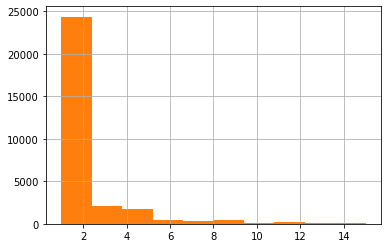

In [15]:
from sklearn.model_selection import train_test_split

train_ids, val_ids = train_test_split(unique_img_ids,
                                      test_size = 0.7, 
                                      stratify = unique_img_ids['ships'])

print(train_ids.shape[0], 'training masks')
print(val_ids.shape[0], 'validation masks')
train_ids['ships'].hist()
val_ids['ships'].hist();

## Mask-R_CNN 
### *region based convolutional neural networks*
 - [what is R-CNN?](https://machinelearningmastery.com/how-to-perform-object-detection-in-photographs-with-mask-r-cnn-in-keras/)
 - [Mask R-CNN, 2017. He, K., et al](https://arxiv.org/abs/1703.06870)
 - [github](https://github.com/abhinavsagar/Mask_RCNN)

In [2]:
UPDATE_MASK_RCNN = False
MASK_RCNN_PATH = 'P:\MyWork\Mask_RCNN'

os.chdir('P:\MyWork')
if UPDATE_MASK_RCNN:
    !rm -rf {MASK_RCNN_PATH}

## clone repo 
## ensure to install requirements in the conda environment
## conda isntall -f requirements.txt
if not os.path.exists(MASK_RCNN_PATH):
    ! git clone https://github.com/matterport/Mask_RCNN
    ! pip install requirements.txt
    ! python setup.py install
    #! curl 'https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5'

sys.path.append(MASK_RCNN_PATH)  
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log    

C:\ProgramData\Anaconda3\envs\kaggle-ship\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\kaggle-ship\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\kaggle-ship\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\kaggle-ship\lib\site-pack

Create a Class for loading the dataset, masks and images.

In [13]:
class AirbusShipDetectionChallengeDataset(utils.Dataset):
    def __init__(self, image_file_dir, ids, masks, image_width=IMAGE_WIDTH, image_height=IMAGE_HEIGHT):
        super().__init__(self)
        self.image_file_dir = image_file_dir
        self.ids = ids
        self.masks = masks
        self.image_width = image_width
        self.image_height = image_height
        
        self.add_class(SHIP_CLASS_NAME, 1, SHIP_CLASS_NAME)
        self.load_dataset()
        
    def load_dataset(self):
        for index, row in self.ids.iterrows():
            image_id = row['ImageId']
            image_path = os.path.join(self.image_file_dir, image_id)
            rle_mask_list = row['RleMaskList']
            self.add_image(
                SHIP_CLASS_NAME,
                image_id=image_id,
                path=image_path,
                width=self.image_width, height=self.image_height,
                rle_mask_list=rle_mask_list)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        rle_mask_list = info['rle_mask_list']
        mask_count = len(rle_mask_list)
        mask = np.zeros([info['height'], info['width'], mask_count],
                        dtype=np.uint8)
        i = 0
        for rel in rle_mask_list:
            if isinstance(rel, str):
                np.copyto(mask[:,:,i], rle_decode(rel))
            i += 1
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        if info['source'] == SHIP_CLASS_NAME:
            return info['path']
        else:
            super(self.__class__, self).image_reference(image_id)

In [14]:
class AirbusShipDetectionChallengeGPUConfig(Config):
    NAME = 'ASDC_GPU'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2
    
    NUM_CLASSES = 2  
    IMAGE_MIN_DIM = IMAGE_WIDTH
    IMAGE_MAX_DIM = IMAGE_WIDTH
    STEPS_PER_EPOCH = 300
    VALIDATION_STEPS = 50
    SAVE_BEST_ONLY = True
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.05

config = AirbusShipDetectionChallengeGPUConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.05
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE           

## Prepare and load training dataset


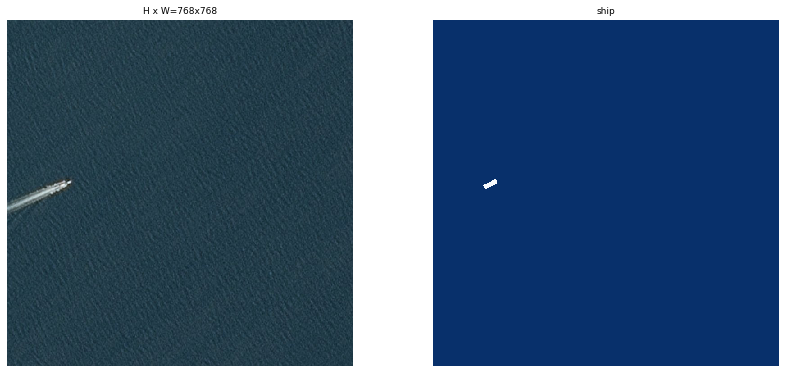

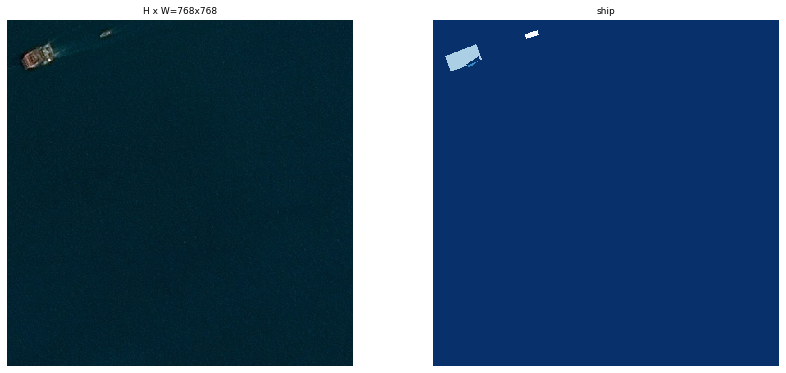

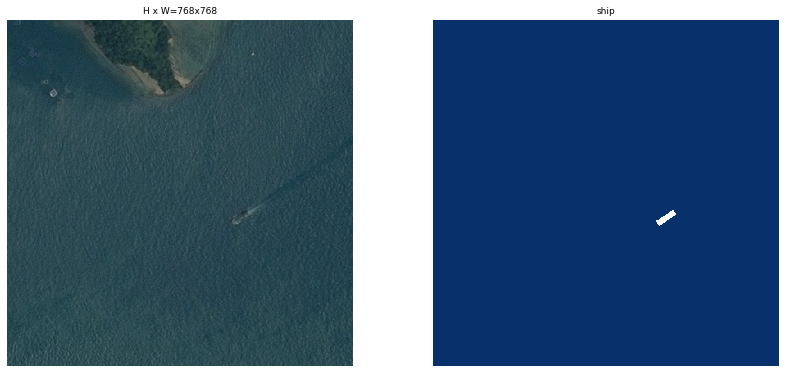

dataset prepare: 13.123603343963623


In [22]:
start_time = time.time()
dataset_train = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DIR, ids=train_ids, masks=training_masks)
dataset_train.prepare()

dataset_val = AirbusShipDetectionChallengeDataset(image_file_dir=TRAIN_DIR, ids=val_ids, masks=training_masks)
dataset_val.prepare()

image_ids = np.random.choice(dataset_train.image_ids, 3)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=1)

end_time = time.time() - start_time
print("dataset prepare: {}".format(end_time))

## Load pre-trained wieghts
Pre-trained weights for MS COCO is loaded to provide a better straing point for training. 

In [26]:
COCO_WEIGHTS_PATH = 'P:\MyWork\Mask_RCNN\mask_rcnn_coco.h5'


start_time = time.time()
model = modellib.MaskRCNN(mode="training",
                          config=config,
                          model_dir='P:\MyWork\kaggle\ShipDetection')

import errno
try:
    weights_path = model.find_last()
    load_weights = True
except FileNotFoundError:
    load_weights = True
    weights_path = COCO_WEIGHTS_PATH
    utils.download_trained_weights(weights_path)
    
if load_weights:
    print("Loading weights: ", weights_path)
    model.load_weights(weights_path, by_name=True, exclude=[
                "mrcnn_class_logits", "mrcnn_bbox_fc",
                "mrcnn_bbox", "mrcnn_mask"])

end_time = time.time() - start_time
print("loading weights: {}".format(end_time))

Instructions for updating:
Colocations handled automatically by placer.
... done downloading pretrained model!
Loading weights:  P:\MyWork\Mask_RCNN\mask_rcnn_coco.h5
loading weights: 59.007481813430786


# Train the model

In [ ]:
start_time = time.time()    
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE * 1.5,
            epochs=2,
            layers='all')
end_time = time.time() - start_time
print("Train model: {}".format(end_time))


Starting at epoch 0. LR=0.0015

Checkpoint Path: P:\MyWork\kaggle\ShipDetection\asdc_gpu20190922T1810\mask_rcnn_asdc_gpu_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

C:\ProgramData\Anaconda3\envs\kaggle-ship\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/2
 39/300 [==>...........................] - ETA: 5:45:21 - loss: 2.3163 - rpn_class_loss: 0.1072 - rpn_bbox_loss: 0.7950 - mrcnn_class_loss: 0.1522 - mrcnn_bbox_loss: 0.7663 - mrcnn_mask_loss: 0.4956

# Inference


In [ ]:
class InferenceConfig(AirbusShipDetectionChallengeGPUConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
infer_model = modellib.MaskRCNN(mode="inference",
                                config=inference_config,
                                model_dir=WORKING_DIR)

model_path = infer_model.find_last()

print("Loading weights from ", model_path)
infer_model.load_weights(model_path, by_name=True)

image_id = np.random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

results = infer_model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

image_ids = np.random.choice(dataset_val.image_ids, 20)
APs = []
inference_start = time.time()
for image_id in image_ids:
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    results = infer_model.detect([image], verbose=1)
    r = results[0]
    visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'])

    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)

inference_end = time.time()
print('Inference Time: %0.2f Minutes'%((inference_end - inference_start)/60))
print("mAP: ", np.mean(APs))
